Sistema de Recomendación con KNN -> MovieLens

**PAQUETES REQUERIDOS**

In [ ]:
import pip
pip.main(['install', 'tqdm'])

In [107]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

**Implementación de Funciones de Similaridad**

In [108]:
def msd_similarity(u:np.array, v:np.array, max_rating:int, min_rating:int) -> float:
    """
    Calcula la similitud MSD (Diferencias Cuadráticas Medias) entre dos vectores.
    
    Parameters:
        u: Primer vector (usuario o ítem).
        v: Segundo vector (usuario o ítem).
    
    Returns:
        float: La similitud MSD entre u y v o None si no se puede calcular.

    """
    sum_r = 0 
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            count += 1
            sum_r += math.pow((u[i] - v[i])/(max_rating - min_rating), 2)
            
    if count > 0:
        sim = 1-(sum_r/float(count))
        return sim
    else:
        return None

def cosine_similarity(u:np.array, v:np.array, max_rating:int, min_rating:int) -> float:
    """
    Calcula la similitud del coseno entre dos vectores.
    
    Cosine_Similarity = u ⋅ v / |u||v|
    
    Parameters:
        u: Primer vector.
        v: Segundo vector.
    
    Returns:
        float: La similitud del coseno o None si no se puede calcular.

    """
    numerador = 0
    denominador_u = 0
    denominador_v = 0
    
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None
    
def correlation_similarity(u:np.array, v:np.array, max_rating:int, min_rating:int) -> float:
    
    """
    Calcula la correlación de Pearson entre dos vectores.
    
    Correlation_Similarity = cov(u, v) / (σ_u * σ_v)
    
    Parameters:
        u: Primer vector.
        v: Segundo vector.
    
    Returns:
        float: La correlación de Pearson o None si no se puede calcular.
    """

    # -- Convertir listas a numpy arrays, reemplazando None por 0
    u = np.array(u, dtype=float)
    v = np.array(v, dtype=float)

    # -- Reemplazar None (o NaN) por 0
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # -- Filtrar los índices donde ambos vectores tienen valores no cero
    mask = (u != 0) & (v != 0)
    
    if np.sum(mask) == 0:
        return None  # No hay valores en común para calcular la correlación

    u_filtered = u[mask]
    v_filtered = v[mask]

    # -- Calcular la media de los vectores
    u_mean = np.mean(u_filtered)
    v_mean = np.mean(v_filtered)

    # -- Calcular la covarianza
    covariance = np.sum((u_filtered - u_mean) * (v_filtered - v_mean))

    # -- Calcular las desviaciones estándar
    std_u = np.std(u_filtered, ddof=0)
    std_v = np.std(v_filtered, ddof=0)

    # Si alguna desvicacion estandar es 0 retornamos None
    if std_u > 0 and std_v > 0:
        return covariance / (std_u * std_v)
    else:
        return None
    
def jmsd_similarity(u:np.array, v:np.array, max_rating:int, min_rating:int) -> float:
    """
    Calcula la similitud de Jensen-Shannon entre dos vectores.
    
    La similitud de Jensen-Shannon se define como:
    JMSD(u, v) = 1 - D_JS(u, v)
    
    Donde D_JS(u, v) es la distancia de Jensen-Shannon entre u y v.

    Parameters:
        u: Primer vector.
        v: Segundo vector.
    
    Returns:
        float: La similitud de Jensen-Shannon o None si no se puede calcular.
    """

    # Convertir listas a numpy arrays
    u = np.array(u, dtype=float)
    v = np.array(v, dtype=float)

    # Reemplazar None (o NaN) por 0
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizar los vectores para que sumen 1 (convertir a distribuciones de probabilidad)
    u_sum = np.sum(u)
    v_sum = np.sum(v)

    if u_sum == 0 or v_sum == 0:
        return None  # No se puede calcular la similitud si uno de los vectores es cero

    # -- Distribución de u
    p = u / u_sum
    # -- Distribución de v
    q = v / v_sum

    # Calcular la mezcla de las dos distribuciones
    m = 0.5 * (p + q)

    # Calcular la divergencia de Kullback-Leibler
    def kl_divergence(p, q):
        return np.sum(np.where(p != 0, p * np.log(p / q), 0))

    # Calcular la distancia de Jensen-Shannon
    d_js = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

    # Calcular la similitud de Jensen-Shannon
    similarity = 1 - d_js

    return similarity

**Cálculo de similaridades**

In [109]:
def calculate_similarities(ratings_matrix:np.array, similarity_metric:object, num_users:int, max_rating:int, min_rating:int) -> list:
    """
    Cálculo de similaridades
    """

    # Creamos una matriz con valores de similaridad a -1
    similarities = [[float('-inf') for _ in range(num_users)] for _ in range(num_users)]
    
    # Recorremos la matriz por usuario
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u, v, max_rating=max_rating, min_rating=min_rating)
        
    return similarities

def rating_average(ratings) -> float:
    
    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


**Cálculo de K-Vecinos**

In [110]:
def calculate_neighbors(similarities_matrix, k_neighbors, num_users):
    
    neighbors = [None for _ in range(num_users)]
    
    for index, similarities in enumerate(tqdm(similarities_matrix, leave=False)):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities), 
                                            key=lambda x:float('-inf') if x[1] is None else x[1], 
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

**Cálculo de Predicciones**

In [111]:
def get_mae(ratings_matrix:np.array, predictions_matrix:np.array):
    """
    Calcula el Error Medio Absoluto (MAE) entre las calificaciones reales y las predicciones.
    
    Parameters:
        ratings_matrix : Matriz de calificaciones reales de los usuarios.
        predictions_matrix : Matriz de predicciones de calificaciones.
    
    Returns:
        float: El MAE promedio de todos los usuarios.
    """
    mae_users = []

    for user_ratings, user_predictions in zip(ratings_matrix, predictions_matrix):
        abs_errors = []
        
        for real, predicted in zip(user_ratings, user_predictions):
            if real is not None and not np.isnan(real):
                abs_errors.append(abs(real - predicted))

        if abs_errors:
            mae_users.append(np.mean(abs_errors))
        else:
            mae_users.append(None)

    # Convertir la lista a numpy array y calcular el MAE ignorando None/NaN
    return np.nanmean(np.array(mae_users, dtype=np.float64), axis=0)

def calculate_deviation_from_mean_prediction(ratings_matrix:np.array, neighbors:list, num_items:int, num_users:int):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(num_items)] for _ in range(num_users)]
    
    # Calculamos la media de los votos de los usuarios
    avg_user_ratings = [rating_average(user) for user in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        for j, v in enumerate(ratings_matrix[0]):
            numerador = 0 
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += ratings_matrix[neighbor][j] - avg_user_ratings[neighbor]
                    denominador += 1
                    
            predictions[i][j] = (avg_user_ratings[i] if denominador == 0 
                                 else avg_user_ratings[i] + (numerador/denominador))
            
            # Ajustamos los votos inferiores a 1 y superiores a 5
            if predictions[i][j] < 1:
                predictions[i][j] = 1
            if predictions[i][j] > 5:
                predictions[i][j] = 5
            
    return predictions

**ANALISIS EXPLORATORIO (EDA)**

Primero hacemos una exploración descriptiva de nuestros datos.

**CARGA DE DATOS**

In [112]:
def read_ratings_matrix(file:str, num_items:int, num_users:int) -> list:
    """
    Data la ruta donde se encuentra un fichero con la estructura [ID_USER::ID_MOVIE::RATING]
    crea una matriz de interacción usuario-artículo. 
    Esta matriz representa las valoraciones que los usuarios han dado a los artículos,
    donde las filas representan a los usuarios y las columnas a los artículos.
    
    Un valor de 0 indica que el usuario no ha valorado el artículo.
    """

    # -- Creamos una lista vacia de NUM_ITEMS elementos por cada usuario 
    RATINGS = [[None for _ in range(num_items)] for _ in range(num_users)] 

    # -- Abre el archivo indicado y lee cada línea separando el contenido de estas por el caracter ::
    # -- que hace referencia a la estructura ID_USER::ID_MOVIE::RATING
    fx = open(file, 'r')
    while True:
        line = fx.readline()
        if not line:
            break
        else:
            l = line.strip()
            l = l.split('::')
            user_id, movie_id, rating = l

            # -- Completar el espacio correspondiente a esta línea en la lista de ratings
            RATINGS[int(user_id)][int(movie_id)] = int(rating)

    # -- Convierte los valores nulos en 0(cero)
    for index in range(len(RATINGS)):
        data = RATINGS[index]
        RATINGS[index] = [0 if x is None else x for x in data]

    return RATINGS

In [113]:
# Número de usuarios e items
NUM_USERS = 943
NUM_ITEMS = 1682

# Notas máximas y mínimas dadas en la matriz de votos
MIN_RATING = 1
MAX_RATING = 5

# Ruta del los datasets de entrenamiento y test
TRAIN_RATINGS_FILE = 'movielens_100k_training.txt'
TEST_RATINGS_FILE = 'movielens_100k_test.txt'

# Lectura de los Datasets de Entrenamiento y Test
train_ratings = np.array(read_ratings_matrix(file=TRAIN_RATINGS_FILE, num_items=NUM_ITEMS, num_users=NUM_USERS))
test_ratings = np.array(read_ratings_matrix(file=TEST_RATINGS_FILE, num_items=NUM_ITEMS, num_users=NUM_USERS))

**Normalizar la matriz**

In [114]:
rating_normalized_train_matrix = train_ratings
#mean_user_rating_train = np.mean(train_ratings, axis=1).reshape(-1, 1)
#rating_normalized_train_matrix = train_ratings - mean_user_rating_train

rating_normalized_test_matrix = test_ratings
#mean_user_rating_test = np.mean(test_ratings, axis=1).reshape(-1, 1)
#rating_normalized_test_matrix = test_ratings - mean_user_rating_test 

In [115]:
# Metricas, K vecinos y predicciones a probar
SIMILARITIES_METRICS = [('MSD', msd_similarity), 
                        ('COSENO', cosine_similarity),
                        ('CORRELACION', correlation_similarity),
                        ('JMSD', jmsd_similarity)]
K_NEIGHBORS = [25, 50, 75, 100, 150, 200, 250, 300, 500]

# Guardo en una lista los experimentos realizados, siendo un experimento una lista con 4 posiciones:
#     1.- Métrica de similaridad
#     2.- Número de vecinos
#     3.- MAE
#     4.- Entrenamiento o Test
experiments = []

for metric in SIMILARITIES_METRICS:
    print(f'Cálculo de similaridad {metric[0]}')
    similarities_matrix = calculate_similarities(ratings_matrix=rating_normalized_train_matrix , similarity_metric=metric[1], num_users=NUM_USERS, max_rating=MAX_RATING, min_rating=MIN_RATING)

    for k in K_NEIGHBORS:
        print(f'{k}-Vecinos')
        neighbors_matrix = calculate_neighbors(similarities_matrix=similarities_matrix, k_neighbors=k, num_users=NUM_USERS)
        
        # Calculamos las predicciones
        predictions = calculate_deviation_from_mean_prediction(ratings_matrix=rating_normalized_train_matrix , neighbors=neighbors_matrix, num_items=NUM_ITEMS, num_users=NUM_USERS)
        
        # Calculamos el MAE para entrenamiento y test
        mae_train = get_mae(ratings_matrix=rating_normalized_train_matrix, predictions_matrix=predictions)
        mae_test = get_mae(ratings_matrix=rating_normalized_test_matrix, predictions_matrix=predictions)
        
        # Añadimos los experimentos a la lista
        experiments.append([metric[0], k, mae_train, "Train"])
        experiments.append([metric[0], k, mae_test, "Test"])

Cálculo de similaridad MSD


  0%|          | 0/943 [00:00<?, ?it/s]

25-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

50-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

75-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

100-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

150-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

200-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

250-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

300-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

500-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Cálculo de similaridad COSENO


  0%|          | 0/943 [00:00<?, ?it/s]

25-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

50-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

75-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

100-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

150-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

200-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

250-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

300-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

500-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Cálculo de similaridad CORRELACION


  0%|          | 0/943 [00:00<?, ?it/s]

25-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

50-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

75-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

100-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

150-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

200-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

250-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

300-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

500-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Cálculo de similaridad JMSD


  0%|          | 0/943 [00:00<?, ?it/s]

C:\Users\ingjo\AppData\Local\Temp\ipykernel_13436\4271891203.py:140: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
C:\Users\ingjo\AppData\Local\Temp\ipykernel_13436\4271891203.py:140: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
C:\Users\ingjo\AppData\Local\Temp\ipykernel_13436\4271891203.py:140: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


25-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

50-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

75-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

100-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

150-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

200-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

250-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

300-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

500-Vecinos


  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

In [116]:
# -- Pasamos los resultados de los experimentos a un DataFrame
df_results = pd.DataFrame.from_records(experiments, columns=['Métrica', 'K-Vecinos', 'MAE', 'Train/Test'])

In [117]:
# -- Mostramos los resultados de los experimentos con los datos de entrenamiento
pd.pivot_table(df_results[df_results['Train/Test']=='Train'], values=['MAE'], index=['K-Vecinos'], columns=['Métrica'])

MAE                              
Métrica   CORRELACION    COSENO      JMSD       MSD
K-Vecinos                                          
25           1.106578  1.076548  1.073987  1.074925
50           1.099522  1.078479  1.076172  1.077809
75           1.096266  1.079937  1.077978  1.079696
100          1.094301  1.081146  1.079465  1.081063
150          1.092056  1.082847  1.081640  1.083042
200          1.090925  1.084024  1.083214  1.084494
250          1.090366  1.084949  1.084410  1.085588
300          1.090217  1.085718  1.085346  1.086484
500          1.090857  1.088131  1.087991  1.088803

In [119]:
# -- Muestra los resultados de los experimentos con los datos de test
pd.pivot_table(df_results[df_results['Train/Test']=='Test'], values=['MAE'], index=['K-Vecinos'], columns=['Métrica'])

MAE                              
Métrica   CORRELACION    COSENO      JMSD       MSD
K-Vecinos                                          
25           1.113011  1.097948  1.092009  1.032207
50           1.094533  1.089192  1.084102  1.027576
75           1.083753  1.083129  1.078995  1.024954
100          1.075946  1.078674  1.075134  1.023093
150          1.064533  1.071331  1.068725  1.020427
200          1.056119  1.065330  1.063515  1.018454
250          1.049391  1.060063  1.058809  1.017011
300          1.044062  1.055238  1.054376  1.015943
500          1.030720  1.039235  1.038962  1.013701

**Graficar resultados**

C:\Users\ingjo\AppData\Local\Temp\ipykernel_13436\396016253.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


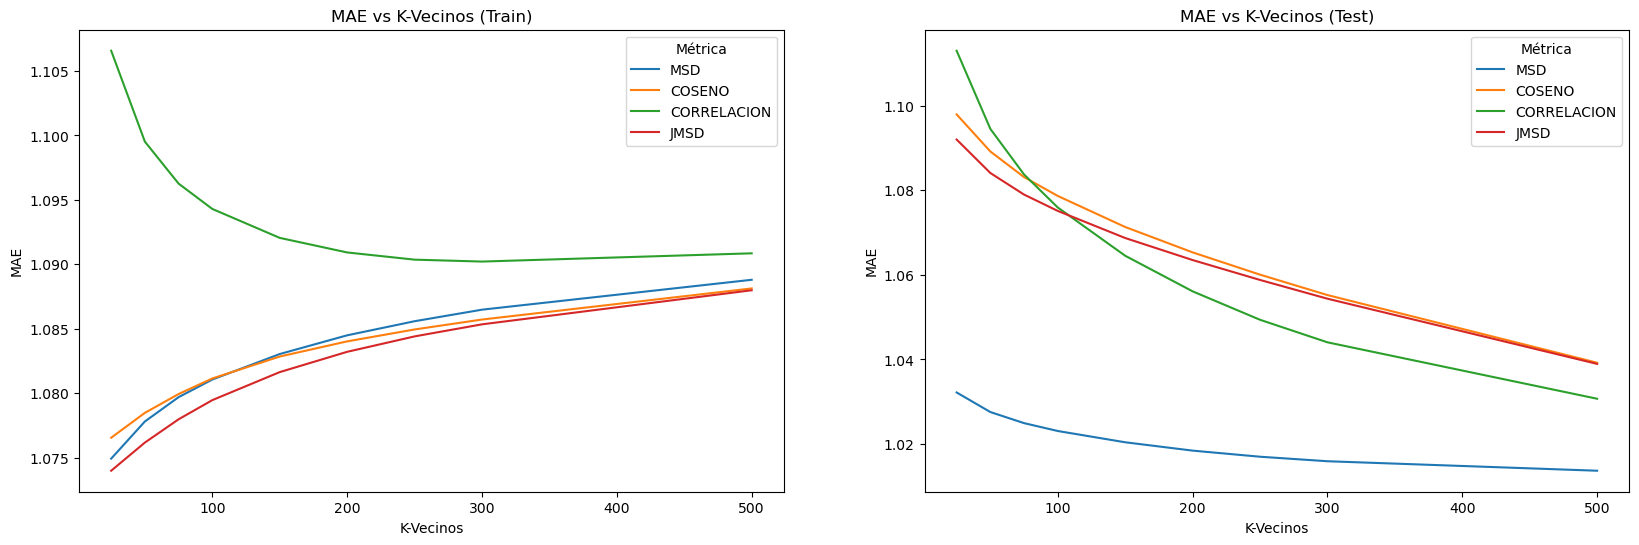

In [120]:
# -- Gráfica del MAE(Mean Absolute Error) con los datos de Entrenamiento
plt.subplots(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.title('MAE vs K-Vecinos (Train)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Métrica", data=df_results[df_results['Train/Test']=='Train'])

# -- Gráfica del MAE(Mean Absolute Error) con los datos de Test
plt.subplot(1, 2, 2)
plt.title('MAE vs K-Vecinos (Test)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Métrica", data=df_results[df_results['Train/Test']=='Test'])

plt.show()

**Entrenar el modelo KNN**

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(rating_normalized_train_matrix)

**Encontrar los K-Neighbors**

In [ ]:
# Encuentra los K-Vecinos de un user_id determinado
target_user_index = 0
distances, indices = knn.kneighbors(rating_normalized_train_matrix[target_user_index].reshape(1, -1), n_neighbors=5)
data = pd.DataFrame({'distances':distances[0], 'indices':indices[0]})
data

**Cálculo de Recomendaciones**

In [71]:
def recomendacion(user_index:int, n_recommendations:int) -> list:
    """
    Devuelve una lista de N identificadores respecto a las películas recomendadas al usuario identificado por un ID.
    """
    distances, indices = knn.kneighbors(train_ratings[user_index].reshape(1, -1), n_neighbors=n_recommendations)
    
    recommended_users = []
    for i in range(1, len(distances.flatten())):
        recommended_users.append(indices.flatten()[i])
    
    return recommended_users

In [ ]:
recomendaciones = recomendacion(user_index=0, n_recommendations=5)
print(recomendaciones)